# TTE Data

TTE (Time-Tagged Event) data is basically a time-series of "counts" where each count is mapped to an energy channel.  It is basically the temporally unbinned representation of CSPEC data (128 energy channels).  We can read a TTE file much the same way we can read a CTIME or CSPEC file.

In [1]:
from gbm import test_data_dir
# import the TTE data class
from gbm.data import TTE

# read a tte file
tte = TTE.open(test_data_dir+'/glg_tte_n9_bn090131090_v00.fit')
print(tte)

glg_tte_n9_bn090131090_v00.fit


Similar to the other datatypes, TTE data are stored in FITS files, and so all the metadata in the headers can be accessed:

In [2]:
# list the headers in the file
tte.headers.keys()

odict_keys(['PRIMARY', 'EBOUNDS', 'EVENTS', 'GTI'])

In [3]:
# print the metadata in the PRIMARY header
tte.headers['PRIMARY']

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = 'GBM_TTE_Reader.pl v2.8' / Software and version creating file         
FILETYPE= 'GBM PHOTON LIST'    / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'NAI_09  '           / Individual detector name                       
OBSERVER= 'Meegan  '        

There is also easy access for certain important properties:

In [4]:
# certain useful properties are easily accessible
print("GTI: {}".format(tte.gti))
print("Trigger time: {}".format(tte.trigtime))
print("Time Range: {}".format(tte.time_range))
print("Energy Range: {}".format(tte.energy_range))
print('# of Energy Channels: {}'.format(tte.numchans))

GTI: [[-25.49109798669815, 300.73552399873734]]
Trigger time: 255060563.149072
Time Range: (-25.49109798669815, 300.73552399873734)
Energy Range: (4.3897295, 2000.0)
# of Energy Channels: 128


The TTE data class is modeled as a wrapper around the ```EventList``` [Data Primitive](./DataPrimitives.ipynb) in ```gbm.data.primitives```, and the underlying data can be accessed via the ```.data``` attribute:

In [5]:
tte.data

Most casual users need not directly worry about the ```EventList``` data primitive, though.  The TTE data objects contain the high-level functionality to perform a lot of common data reduction.  For example, if we only want to work with a short time segment of TTE data in the file, we can take a slice of the data and return a new fully-functional data object with the time-sliced data:

In [6]:
# slice from -10 to +10 s
time_sliced_tte = tte.slice_time([-10.0, 10.0])
print(time_sliced_tte.time_range)

(-9.999035984277725, 9.998922020196915)


And you can slice in energy:

In [7]:
# slice from ~50 keV to ~300 keV
energy_sliced_tte = tte.slice_energy((50.0, 300.0))
print(energy_sliced_tte.energy_range)

(48.08033, 304.68533)


Making a lightcurve using TTE data is slightly more complicated than it is for the pre-binned data because the TTE is temporally unbinned.  So first the data has to be binned, and then it can be displayed.  On the [CTIME/CSPEC](./PhaiiData.ipynb) page, we were briefly introduced to the capability of *rebinning* pre-binned data.  Here, we want to *bin* unbinned data.  In the ```gbm.binning``` module, there are two sub-modules containing various binning algorithms, one for pre-binned data, the other for unbinned data.  We should choose the sub-module that is appropriate for the data that we are using.

In [8]:
# import the bin_by_time algorithm for unbinned data
# This function is the unbinned equivalent of gbm.binning.binned.rebin_by_time
from gbm.binning.unbinned import bin_by_time

Once we've identified the binning algorithm we want to use, then we can *convert* our TTE data object to a PHAII object similar to CTIME/CSPEC:

In [9]:
# bin TTE to 1.024 s resolution. 
# time_ref is the reference time for binning;
# if not set, it will bin starting at the beginning of the data
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)
type(phaii)

gbm.data.phaii.Cspec

Well that's cool, but why is it a ``Cspec`` object now?  It's Cspec because TTE has 128 energy channels, just like CSPEC.  We'll see what the spectrum looks like in a sec.  But first, let's look at the lightcurve.  Since it's a PHAII object, we can make a lightcurve plot the same way we would make one using pre-binned data:

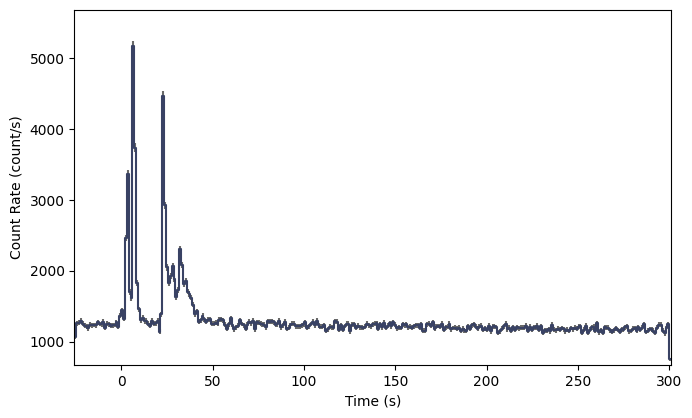

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from gbm.plot import Lightcurve

lcplot = Lightcurve(data=phaii.to_lightcurve())
plt.show()

A nice looking GRB!  Now if you wanted to rebin the data, you could certainly rebin the PHAII object, but if you want to leverage the full power and flexibility of TTE, it would be good to (re)bin the TTE data using the algorithm and settings of your choice.

To plot the spectrum, we don't have to worry about binning the data, since the TTE is already necessarily pre-binned in energy.  So we can make a spectrum plot the same way we make one for CTIME/CSPEC without any extra steps:

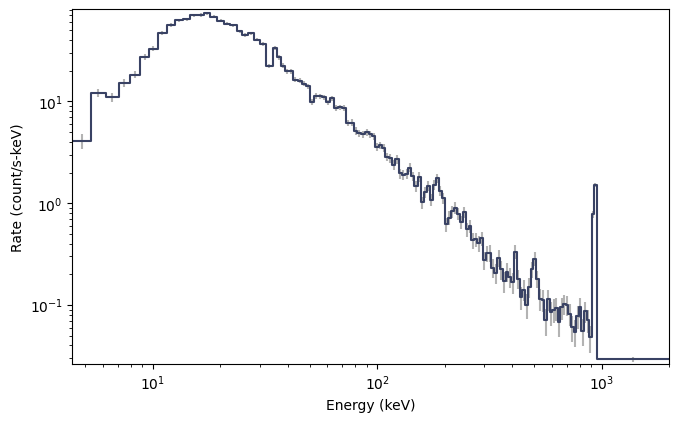

In [11]:
from gbm.plot import Spectrum

# integrate over time from 0-10 s
spectrum = tte.to_spectrum(time_range=(0.0, 10.0))

specplot = Spectrum(data=spectrum)
plt.show()

A very nice count spectrum, certainly much prettier than the CTIME spectrum!  Note that this is integrated over the full time range of the data. Perhaps the spectral resolution is a little bit higher than you care for (i.e. studying a weak source).  You can rebin the count spectrum, but remember that the energy is pre-binned, so you need to use the appropriate class of algorithms:

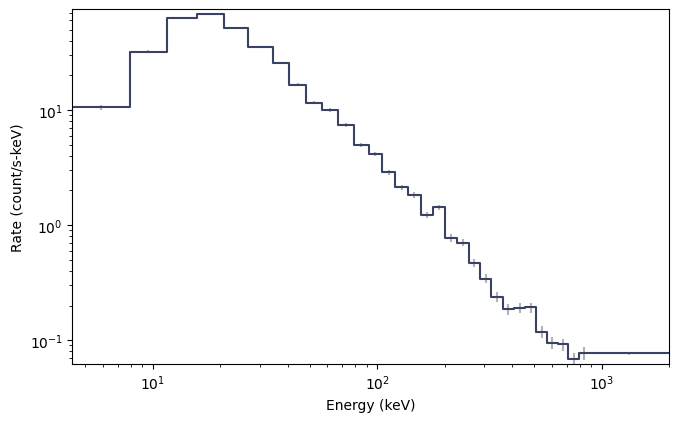

In [12]:
from gbm.binning.binned import combine_by_factor

# rebin the count spectrum by a factor of 4
rebinned_energy = tte.rebin_energy(combine_by_factor, 4)

rebinned_spectrum = rebinned_energy.to_spectrum(time_range=(0.0, 10.0))
specplot = Spectrum(data=rebinned_spectrum)
plt.show()

As with the pre-binned types, we can convert one or more time selections to a single spectrum PHA object.  You can do this from TTE without having to bin in time:

In [13]:
# create a PHA object by integrating over 0-10 s and 30-50 s
pha = tte.to_pha(time_ranges=[(0.0, 10.0), (30.0, 50.0)])

Sometimes, you might want to save snippets of TTE, or even merge your TTE snippets into one file and write it to file for later. Guess what?  You can do that, too:

In [14]:
time_sliced_tte2 = tte.slice_time([30.0, 50.0])

# merge our new time slice with the time slice we made earlier
tte_slices_merged = TTE.merge([time_sliced_tte, time_sliced_tte2])
tte_slices_merged.time_range

(-9.999035984277725, 49.99965399503708)

And then you can write it as a fully-qualified TTE FITS file using
```python
tte_slices_merged.write('./', filename='my_first_custom_tte.fit')
```

You've just learned all about the primary GBM Science Data!  Follow on to learn about the GBM detector [response files](./Responses.ipynb)